In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from pathlib import Path

In [3]:
import os, sys

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import cosmoplotian
import cosmoplotian.colormaps
import matplotlib as mpl
string_cmap = "div yel grn"
#string_cmap = "RdYlBu"
cmap = mpl.cm.get_cmap(string_cmap)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[cmap(0.2), "k", "red"]) 
plt.rcParams['text.usetex'] = True
from matplotlib import patheffects
from matplotlib import text
def outline_text(ax):
    """Add a white outline to all text to make it stand out from the
    background.
    """
    effects = [patheffects.withStroke(linewidth=2, foreground='w')]
    for artist in ax.findobj(text.Text):
        artist.set_path_effects(effects)

In [4]:
PLOT_DIR = Path(os.path.expandvars("$HOME")) / 'vae-paper' / 'figures'
PLOT_DIR.mkdir(exist_ok=True, parents=True)

Setup checkpointing:

## Setup default I/O directory to scratch

In [5]:
DIR = Path(os.path.expandvars("$SCRATCH")) / "dustvaeder"
%ls $DIR

I_GNILC_DATASET.cdf               semantic_sequence_dataset.npy
checkpoint                        test_predicted.npy
data_imputation_dataset.npy       test_true.npy
datasets/                         tflogs/
models/                           train_predicted.npy
novel_samples.npy                 train_true.npy
plots/                            trained_vae.data-00000-of-00002
predicted_test.npy                trained_vae.data-00001-of-00002
reconstructed_w_res_dataset.npy   trained_vae.index
results/                          training_dataset.npy
semantic_interpolation_block.npy  true_test.npy


# Build network

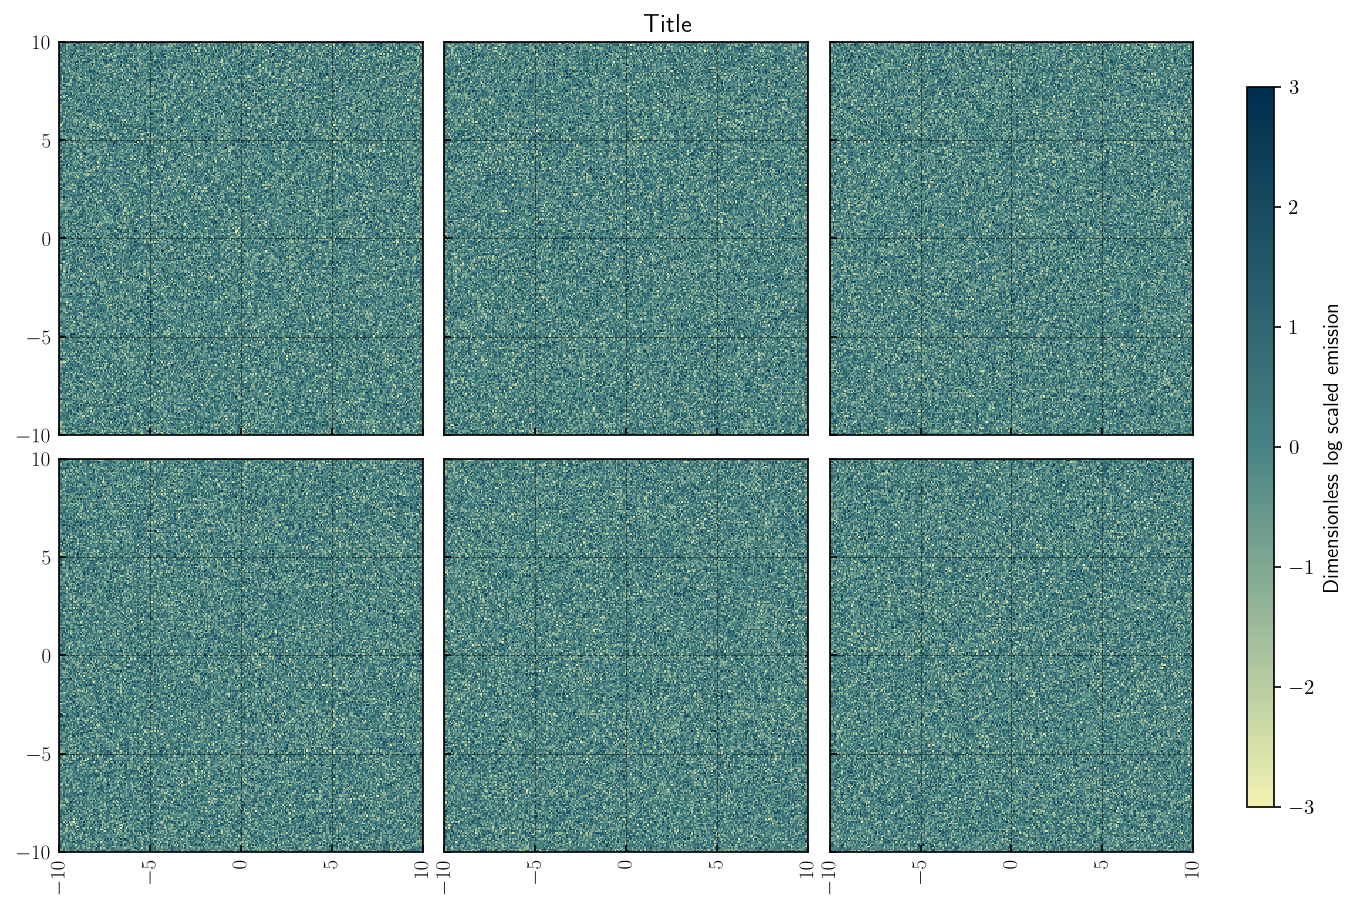

In [6]:
def make_prediction_plot(arr1, arr2, title):
    # assume direct output of model prediction with shape (n_batch, x, y, n_channel)
    assert arr1.ndim == 4
    assert arr2.ndim == 4
    # assume only one channel
    assert arr1.shape[-1] == 1
    assert arr2.shape[-1] == 1
    # assume 4 samples
    assert arr1.shape[0] == 3
    assert arr2.shape[0] == 3
    
    fig, axes = plt.subplots(ncols=3, nrows=2, dpi=150, figsize=(9, 6), sharex=True, sharey=True)

    kwds = {
        'extent': [-10, 10, -10, 10],
        'aspect': 'auto',
        'interpolation': 'nearest',
        'origin': 'lower',
        'cmap': 'div yel grn',
        'vmin': -3,
        'vmax': 3
    }
    
    fig.suptitle(title)
    axes[0, 0].imshow(arr1[0, :, :, 0], **kwds)
    #axes[0, 0].set_ylabel("$\phi~{\rm [^\circ]}$")
    axes[0, 1].imshow(arr1[1, :, :, 0], **kwds)
    axes[0, 2].imshow(arr1[2, :, :, 0], **kwds)
    axes[1, 0].imshow(arr2[0, :, :, 0], **kwds)
    #axes[1, 0].set_ylabel("$\phi~{\rm [^\circ]}$")
    #axes[1, 0].set_xlabel("$\theta~{\rm [^\circ]}$")
    img = axes[1, 1].imshow(arr2[1, :, :, 0], **kwds)
    #axes[1, 1].set_xlabel("$\theta~{\rm [^\circ]}$")
    img = axes[1, 2].imshow(arr2[2, :, :, 0], **kwds)
    #axes[1, 2].set_xlabel("$\theta~{\rm [^\circ]}$")

    for ax in axes.flatten():
        ax.xaxis.set_ticks([-10, -5, 0, 5, 10])
        ax.yaxis.set_ticks([-10, -5, 0, 5, 10])
        ax.grid(linestyle='--', linewidth=0.5, color='k', alpha=0.5)
        ax.tick_params(axis='both', direction='in')
        ax.tick_params(axis='x', rotation=90)
        outline_text(ax)

    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.05, right=0.89, wspace=0.06, hspace=0.06)

    cbax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(img, cax=cbax)

    cbar.set_ticks([-3, -2, -1, 0, 1, 2, 3])
    cbar.set_label("Dimensionless log scaled emission")
    return fig, axes

fig, axes = make_prediction_plot(np.random.randn(3, 256, 256, 1), np.random.randn(3, 256, 256 ,1), 'Title')

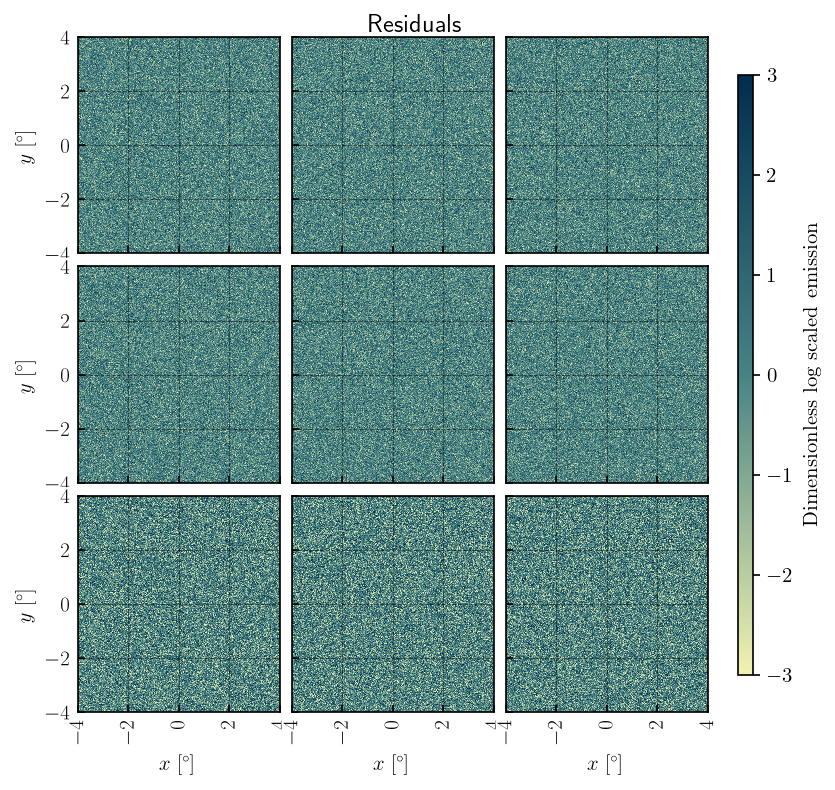

In [7]:
def make_prediction_plot_with_residuals(arr1, arr2, title):
    # assume direct output of model prediction with shape (n_batch, x, y, n_channel)
    assert arr1.ndim == 4
    assert arr2.ndim == 4
    # assume only one channel
    assert arr1.shape[-1] == 1
    assert arr2.shape[-1] == 1
    # assume 4 samples
    assert arr1.shape[0] == 3
    assert arr2.shape[0] == 3
    
    residuals = arr1 - arr2
    
    fig, axes = plt.subplots(ncols=3, nrows=3, dpi=150, figsize=(5, 5), sharex=True, sharey=True)

    kwds = {
        'extent': [-4, 4, -4, 4],
        'aspect': 'auto',
        'interpolation': 'nearest',
        'origin': 'lower',
        'cmap': 'div yel grn',
        'vmin': -3,
        'vmax': 3
    }
    
    fig.suptitle(title)
    axes[0, 0].imshow(arr1[0, :, :, 0], **kwds)
    axes[0, 0].set_ylabel("$y~{\\rm [^\\circ]}$")
    axes[0, 1].imshow(arr1[1, :, :, 0], **kwds)
    axes[0, 2].imshow(arr1[2, :, :, 0], **kwds)
    axes[1, 0].imshow(arr2[0, :, :, 0], **kwds)
    axes[1, 0].set_ylabel("$y~{\\rm [^\\circ]}$")
    axes[2, 0].set_ylabel("$y~{\\rm [^\\circ]}$")
    
    img = axes[1, 1].imshow(arr2[1, :, :, 0], **kwds)
    img = axes[1, 2].imshow(arr2[2, :, :, 0], **kwds)
    
    axes[2, 0].imshow(residuals[0, :, :, 0], **kwds)
    axes[2, 0].set_xlabel("$x~{\\rm [^\\circ]}$")
    axes[2, 1].imshow(residuals[1, :, :, 0], **kwds)
    axes[2, 1].set_xlabel("$x~{\\rm [^\\circ]}$")
    axes[2, 2].imshow(residuals[2, :, :, 0], **kwds)
    axes[2, 2].set_xlabel("$x~{\\rm [^\\circ]}$")
    
    for ax in axes.flatten():
        ax.xaxis.set_ticks([-4, -2, 0, 2, 4])
        ax.yaxis.set_ticks([-4, -2, 0, 2, 4])
        ax.grid(linestyle='--', linewidth=0.5, color='k', alpha=0.5)
        ax.tick_params(axis='both', direction='in')
        ax.tick_params(axis='x', rotation=90)
        outline_text(ax)

    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.05, right=0.89, wspace=0.06, hspace=0.06)

    cbax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(img, cax=cbax)

    cbar.set_ticks([-3, -2, -1, 0, 1, 2, 3])
    cbar.set_label(r"{\rm Dimensionless log scaled emission}")
    return fig, axes

fig, axes = make_prediction_plot_with_residuals(np.random.randn(3, 256, 256, 1), np.random.randn(3, 256, 256, 1), "Residuals")


In [8]:
reconstructed_w_res_dataset = np.load(DIR / "reconstructed_w_res_dataset.npy")

fig, axes = make_prediction_plot(reconstructed_w_res_dataset[:3], reconstructed_w_res_dataset[3:],)

TypeError: make_prediction_plot() missing 1 required positional argument: 'title'

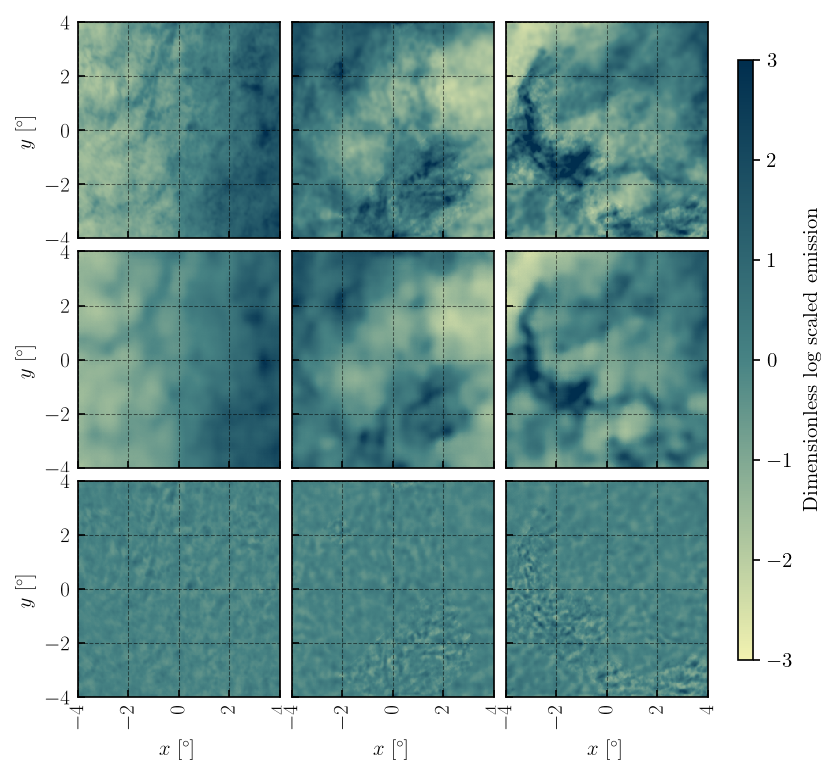

In [9]:
reconstructed_w_res_dataset = np.load(DIR / "reconstructed_w_res_dataset.npy")
fig, axes = make_prediction_plot_with_residuals(reconstructed_w_res_dataset[:3], reconstructed_w_res_dataset[3:], '')
fig.savefig(PLOT_DIR / "reconstruciton_w_res.pdf", bbox_inches='tight')

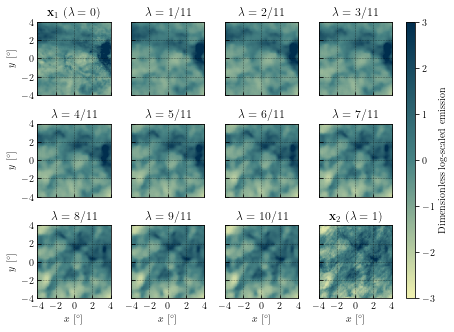

In [10]:
def make_semantic_sequence_plot(arr, title):
    # assume direct output of model prediction with shape (n_batch, x, y, n_channel)
    assert arr.ndim == 4
    # assume only one channel
    assert arr.shape[-1] == 1
    # assume 4 samples
    assert arr.shape[0] == 12
    
    #fig, axes = plt.subplots(ncols=4, nrows=3, dpi=150, figsize=(6, 3), sharex=True, sharey=True)
    nrows = 3
    ncols = 4
    fig = plt.figure(constrained_layout=True, figsize=(ncols * 1.55, nrows * 1.5))

    imshow_kwds = {
        'extent': [-4, 4, -4, 4],
        'aspect': 'auto',
        'interpolation': 'nearest',
        'origin': 'lower',
        'cmap': 'div yel grn',
        'vmin': -3,
        'vmax': 3
    }


    height_ratios = [1] * nrows
    width_ratios = [1] * ncols + [0.1]

    msgs = [
        r"$\mathbf{x}_1~(\lambda=0)$",
        r"$\lambda=1/11$",
        r"$\lambda=2/11$",
        r"$\lambda=3/11$",
        r"$\lambda=4/11$",
        r"$\lambda=5/11$",
        r"$\lambda=6/11$",
        r"$\lambda=7/11$",
        r"$\lambda=8/11$",
        r"$\lambda=9/11$",
        r"$\lambda=10/11$",
        r"$\mathbf{x}_2~(\lambda=1)$"
    ]
    
    spec = fig.add_gridspec(ncols=ncols + 1, nrows=nrows, width_ratios=width_ratios, height_ratios=height_ratios)
    k = 0
    for i in range(nrows):
        for j in range(ncols):
            ax = fig.add_subplot(spec[i, j])
            ax.set_box_aspect(1)
            img = ax.imshow(arr[k, :, :, 0], **imshow_kwds)
            ax.grid(linestyle='--', linewidth=0.5, color='k', alpha=0.5)
            ax.tick_params(axis='both', direction='in')
            ax.xaxis.set_ticks([-4, -2, 0, 2, 4])
            ax.yaxis.set_ticks([-4, -2, 0, 2, 4])
            ax.set_title(msgs[k])
            if i == nrows - 1:
                ax.set_xlabel(r"$x~{\rm [^\circ]}$")
                
            if j == 0:
                ax.set_ylabel(r"$y~{\rm [^\circ]}$")  
            k += 1
            if j != 0:
                ax.yaxis.set_ticklabels([])
            if i != 2:
                ax.xaxis.set_ticklabels([])
    cbax = fig.add_subplot(spec[:, -1])
    cbar = fig.colorbar(img, cax=cbax)

    cbar.set_ticks([-3, -2, -1, 0, 1, 2, 3])
    cbar.set_label(r"{\rm Dimensionless log-scaled emission}")
    return fig, ax

semantic_sequence_dataset = np.load(DIR / "semantic_sequence_dataset.npy")
fig, ax = make_semantic_sequence_plot(semantic_sequence_dataset, title="")
fig.savefig(PLOT_DIR / "semantic_interpolation.pdf", bbox_inches='tight')


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

NameError: name 'imshow_kwds' is not defined

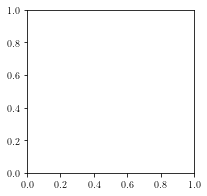

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
img = ax.imshow(semantic_sequence_dataset[0, :, :, 0], **imshow_kwds)
img.set_data(semantic_sequence_dataset[1, :, :, 0])

In [15]:
semantic_sequence_dataset = np.load("/global/cscratch1/sd/bthorne/dustvaeder/semantic_interpolation_block.npy")

In [27]:
f"{100 / 2:.02f}"

'50.00'

MovieWriter ffmpeg unavailable; using Pillow instead.


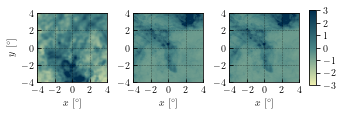

In [64]:
plt.rcParams['text.usetex'] = True
nrows = 1
ncols = 3
fig = plt.figure(constrained_layout=True, figsize=(ncols * 1.55, nrows * 1.5))
height_ratios = [1] * nrows
width_ratios = [1] * ncols + [0.1]
spec = fig.add_gridspec(ncols=ncols + 1, nrows=nrows, width_ratios=width_ratios, height_ratios=height_ratios)

imshow_kwds = {
        'extent': [-4, 4, -4, 4],
        'aspect': 'auto',
        'interpolation': 'nearest',
        'origin': 'lower',
        'cmap': 'div yel grn',
        'vmin': -3,
        'vmax': 3
    }

ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[0, 2])

ax1.set_ylabel("$y~{\\rm [^\\circ]}$")
ax1.set_xlabel("$x~{\\rm [^\\circ]}$")
ax2.set_xlabel("$x~{\\rm [^\\circ]}$")
ax3.set_xlabel("$x~{\\rm [^\\circ]}$")

ax1.imshow(semantic_sequence_dataset[0, :, :, 0], **imshow_kwds)
ax3.imshow(semantic_sequence_dataset[-1, :, :, 0], **imshow_kwds)

cbax = fig.add_subplot(spec[:, -1])
cbar = fig.colorbar(img, cax=cbax)

cbar.set_ticks([-3, -2, -1, 0, 1, 2, 3])
#cbar.set_label("Normalized emission")
img = ax2.imshow(semantic_sequence_dataset[0, :, :, 0], **imshow_kwds)

for a in [ax1, ax2, ax3]:
    a.set_box_aspect(1)
    a.grid(linestyle='--', linewidth=0.5, color='k', alpha=0.5)
    a.tick_params(axis='both', direction='in')
    a.xaxis.set_ticks([-4, -2, 0, 2, 4])
    a.yaxis.set_ticks([-4, -2, 0, 2, 4])

def init():
    return img

def animate(i):
    img.set_data(semantic_sequence_dataset[1+i, :, :, 0])
    return img

ani = FuncAnimation(fig, animate, frames=np.arange(101, dtype=int), init_func=init)
ani.save("animation.gif", dpi=300)

In [ ]:
novel_samples = np.load(DIR / "novel_samples.npy")

MovieWriter ffmpeg unavailable; using Pillow instead.


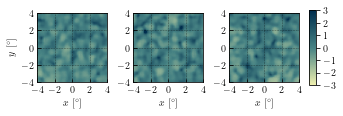

In [70]:
plt.rcParams['text.usetex'] = True
nrows = 1
ncols = 3
fig = plt.figure(constrained_layout=True, figsize=(ncols * 1.55, nrows * 1.5))
height_ratios = [1] * nrows
width_ratios = [1] * ncols + [0.1]
spec = fig.add_gridspec(ncols=ncols + 1, nrows=nrows, width_ratios=width_ratios, height_ratios=height_ratios)

imshow_kwds = {
        'extent': [-4, 4, -4, 4],
        'aspect': 'auto',
        'interpolation': 'nearest',
        'origin': 'lower',
        'cmap': 'div yel grn',
        'vmin': -3,
        'vmax': 3
    }

ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[0, 2])

ax1.set_ylabel("$y~{\\rm [^\\circ]}$")
ax1.set_xlabel("$x~{\\rm [^\\circ]}$")
ax2.set_xlabel("$x~{\\rm [^\\circ]}$")
ax3.set_xlabel("$x~{\\rm [^\\circ]}$")

img1 = ax1.imshow(novel_samples[0, :, :, 0], **imshow_kwds)
img2 = ax2.imshow(novel_samples[1, :, :, 0], **imshow_kwds)
img3 = ax3.imshow(novel_samples[2, :, :, 0], **imshow_kwds)

cbax = fig.add_subplot(spec[:, -1])
cbar = fig.colorbar(img, cax=cbax)

cbar.set_ticks([-3, -2, -1, 0, 1, 2, 3])
#cbar.set_label("Normalized emission")


for a in [ax1, ax2, ax3]:
    a.set_box_aspect(1)
    a.grid(linestyle='--', linewidth=0.5, color='k', alpha=0.5)
    a.tick_params(axis='both', direction='in')
    a.xaxis.set_ticks([-4, -2, 0, 2, 4])
    a.yaxis.set_ticks([-4, -2, 0, 2, 4])

def init():
    return img1

def animate(i):
    img1.set_data(novel_samples[0+i*3, :, :, 0])
    img2.set_data(novel_samples[1+i*3, :, :, 0])
    img3.set_data(novel_samples[2+i*3, :, :, 0])
    return img1, img2, img3

ani = FuncAnimation(fig, animate, frames=np.arange(150, dtype=int), init_func=init)
ani.save("animation_novel_samples.gif", fps=2, dpi=300)

In [56]:
def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

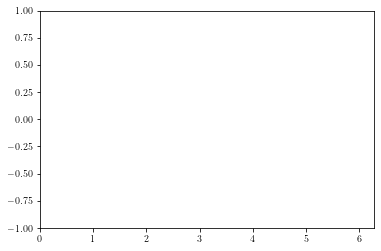

In [14]:
fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
plt.show()

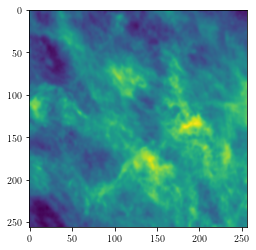

In [88]:
plt.imshow(semantic_sequence_dataset[-1,:,:,0])

In [66]:
print(novel_samples.shape)

(500, 256, 256, 1)


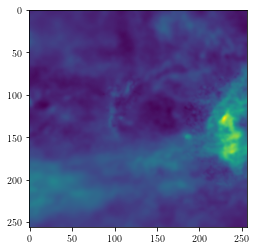

In [89]:
plt.imshow(semantic_sequence_dataset[0,:,:,0])

In [90]:
print(semantic_sequence_dataset.shape)

(12, 256, 256, 1)


### Data imputation

#### Mask 

In [ ]:
import copy

In [ ]:
def make_missing_window_plot(arr, title):
    # assume direct output of model prediction with shape (n_batch, x, y, n_channel)
    assert arr.ndim == 4
    # assume only one channel
    assert arr.shape[-1] == 1
    # assume 4 samples
    assert arr.shape[0] == 9
    
    fig, axes = plt.subplots(ncols=3, nrows=3, dpi=150, figsize=(7, 6), sharex=True, sharey=True)

    kwds = {
        'extent': [-4, 4, -4, 4],
        'aspect': 'auto',
        'interpolation': 'nearest',
        'origin': 'lower',
        'cmap': 'div yel grn',
        'vmin': -3,
        'vmax': 3
    }
    fig.suptitle(title)
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='gray')
    
    axes[0, 0].imshow(arr[0, :, :, 0], **kwds)
    axes[0, 0].set_ylabel(r"$y~{\rm [^\circ]}$")
    axes[0, 1].imshow(arr[1, :, :, 0], **kwds)
    axes[0, 2].imshow(arr[2, :, :, 0], **kwds)
    
    axes[1, 0].imshow(arr[3, :, :, 0], **kwds)
    axes[1, 0].set_ylabel(r"$y~{\rm [^\circ]}$")
    axes[1, 1].imshow(arr[4, :, :, 0], **kwds)
    axes[1, 2].imshow(arr[5, :, :, 0], **kwds)
    
    axes[2, 0].imshow(arr[6, :, :, 0], **kwds)
    axes[2, 0].set_ylabel(r"$y~{\rm [^\circ]}$")
    axes[2, 0].set_xlabel(r"$x~{\rm [^\circ]}$")
    axes[2, 1].imshow(arr[7, :, :, 0], **kwds)
    axes[2, 1].set_xlabel(r"$x~{\rm [^\circ]}$")
    img = axes[2, 2].imshow(arr[8, :, :, 0], **kwds)
    axes[2, 2].set_xlabel(r"$x~{\rm [^\circ]}$")

    for ax in axes.flatten():
        ax.xaxis.set_ticks([-4, -2, 0, 2, 4])
        ax.yaxis.set_ticks([-4, -2, 0, 2, 4])
        ax.grid(linestyle='--', linewidth=0.5, color='k', alpha=0.5)
        ax.tick_params(axis='both', direction='in')
        ax.tick_params(axis='x', rotation=90)
        outline_text(ax)

    msgs = [
        r"$x_1$",
        r"$x_2$",
        r"$x_3$",
        r"$A_1 x_1 + n$",
        r"$A_2 x_2 + n$",
        r"$A_3 x_3 + n$",
        r"$g_\phi(z_1^{\rm MAP})$",
        r"$g_\phi(z_2^{\rm MAP})$",
        r"$g_\phi(z_3^{\rm MAP})$",
    ]
    for ax, msg in zip(axes.flatten(), msgs):
        ax.annotate(msg, xy=(0.03, 0.91), xycoords='axes fraction')
        outline_text(ax)
        
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.05, right=0.89, wspace=0.06, hspace=0.06)

    cbax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(img, cax=cbax)

    cbar.set_ticks([-3, -2, -1, 0, 1, 2, 3])
    cbar.set_label(r"{\rm Dimensionless log-scaled emission}")
    return fig, ax
fig, ax = make_missing_window_plot(np.random.randn(9, 256, 256, 1), title='Data imputation')

In [ ]:
data_imputation_dataset = np.load(DIR / "data_imputation_dataset.npy")

In [ ]:
fig, ax = make_missing_window_plot(data_imputation_dataset, title='')
fig.savefig(PLOT_DIR / "data_imputation.pdf", bbox_inches='tight')

